See if you can create graphs that show that the flux is being predicted correctly in addition to the internal species metabolite values. 

In [1]:
SEED = 1
import random

import tellurium as te
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt

import cobra
import os
os.getcwd()

'c:\\Users\\user\\Documents\\research\\BMCA-pipeline\\notebooks'

In [2]:
os.chdir('..')
from src import antemll, util
os.chdir('notebooks')

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Generating data for running through the pipeline.

Running BMCA on BioModel 64

In [3]:
# load the Teusink model
Teusink_ant = '../models/Antimony/BIOMD0000000064_e.ant'
data_file = '../data/generated_data/ogTeusink/EtOH/BIOMD0000000064_e_1.0.csv'
data = pd.read_csv(data_file)

Comparing flux values, original and perturbed

In [4]:
_ = data.transpose().sort_index()
# _.rename({0: "unperturbed ss", 1: "EtOH -50%"}, axis=1, inplace=True)
_.loc['v_':'v_z']

0           1           2
v_vADH    129.215909  129.324678  129.107789
v_vALD     77.349527   77.364084   77.334995
v_vATP     84.532764   84.721188   84.345588
v_vENO    136.496807  136.582817  136.411275
v_vG3PDH   18.202246   18.145350   18.258715
v_vGAPDH  136.496807  136.582817  136.411275
v_vGLK     88.149527   88.164084   88.134995
v_vGLT     88.149527   88.164084   88.134995
v_vGLYCO    6.000000    6.000000    6.000000
v_vPDC    136.496807  136.582817  136.411275
v_vPFK     77.349527   77.364084   77.334995
v_vPGI     77.349527   77.364084   77.334995
v_vPGK    136.496807  136.582817  136.411275
v_vPGM    136.496807  136.582817  136.411275
v_vPYK    136.496807  136.582817  136.411275
v_vSUC      3.640449    3.629070    3.651743
v_vTreha    2.400000    2.400000    2.400000

Calculating the steady state concentrations of the Teusink model when EtOH concentration is halved. 

Predicting the steady state concentration values 

In [5]:
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
BIOMD64 = antemll.antemll(Teusink_ant, data_file, '../models/sbml/BIOMD64_cobra_sbml.xml')
chi = BIOMD64.calculate_Smallbone_ss(BIOMD64.Ex, BIOMD64.Ey)
# print(np.exp(chi.to_numpy()))

No objective coefficients in model. Unclear what should be optimized


../models/Antimony/BIOMD0000000064_e_cobra.ant


In [6]:
metabolites = data[r.getFloatingSpeciesIds()]
metabolites

P       G6P      TRIO       NAD       ACE       P2G       BPG  \
0  6.308882  1.033246  0.777524  1.545560  0.170114  0.044844  0.000330   
1  6.316695  1.036497  0.778032  1.545813  0.169583  0.044968  0.000332   
2  6.301110  1.030038  0.777021  1.545307  0.170642  0.044721  0.000327   

       GLCi       F6P       PEP       PYR      F16P       P3G      NADH  
0  0.098759  0.112813  0.073617  8.523152  0.601908  0.356484  0.044440  
1  0.098533  0.113374  0.073934  8.536235  0.602611  0.357364  0.044187  
2  0.098984  0.112259  0.073305  8.510184  0.601212  0.355615  0.044693

In [7]:
(np.exp(BIOMD64.xn[list((chi.T).columns)]))*BIOMD64.x_star[:-1]

P       G6P      TRIO       NAD       ACE       P2G       BPG  \
0  6.308882  1.033246  0.777524  1.545560  0.170114  0.044844  0.000330   
1  6.316695  1.036497  0.778032  1.545813  0.169583  0.044968  0.000332   
2  6.301110  1.030038  0.777021  1.545307  0.170642  0.044721  0.000327   

       GLCi       F6P       PEP       PYR      F16P       P3G  
0  0.098759  0.112813  0.073617  8.523152  0.601908  0.356484  
1  0.098533  0.113374  0.073934  8.536235  0.602611  0.357364  
2  0.098984  0.112259  0.073305  8.510184  0.601212  0.355615

Text(0, 0.5, 'x values using Smallbone ss')

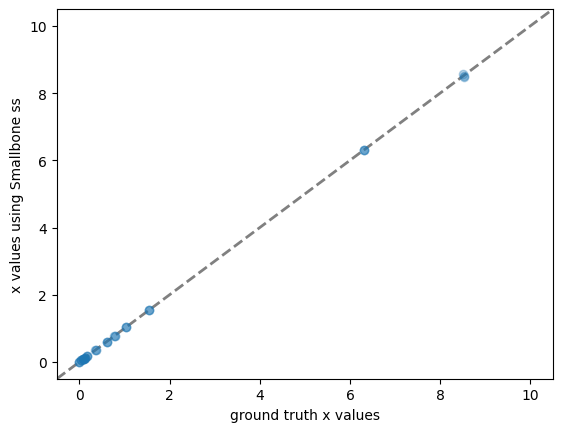

In [8]:
plt.scatter(np.exp(BIOMD64.xn[list((chi.T).columns)])*BIOMD64.x_star[:-1], 
            np.exp(chi.T)*BIOMD64.x_star[:-1], alpha=0.3, zorder=100)
plt.axline([0, 0], [10, 10], c='gray', linestyle='dashed', linewidth=2)

plt.title('')
plt.xlabel('ground truth x values')
plt.ylabel('x values using Smallbone ss')

Plotting relative changes in EtOH by relative changes in steady state intracelluar metabolite concentrations (Figure 3 in Smallbone et al. )

In [7]:
EtOH_scale = np.logspace(-1, 1, num=22)[:-2]
EtOH_scale

array([0.1       , 0.12451971, 0.15505158, 0.19306977, 0.24040992,
       0.29935773, 0.37275937, 0.46415888, 0.57796929, 0.71968567,
       0.8961505 , 1.11588399, 1.38949549, 1.73019574, 2.15443469,
       2.6826958 , 3.34048498, 4.15956216, 5.17947468, 6.44946677])

In [12]:
def calculate_relative_change(metabolite): 
    metabolite_scale = []

    for change in EtOH_scale: 
        r.resetAll()
        r.ETOH =(change * r.ETOH)
        # print(s.ETOH)
        r.steadyState()
        
        #s.simulate(0,50)
        #s.plot(title=change)
        
        metabolite_scale.append(r.getValue(metabolite))

    # calculate the relative change in BPG
    r.resetAll()
    r.steadyState()
    met_ss = r.getValue(metabolite)
    met_scale = np.array(metabolite_scale) / met_ss

    return met_scale

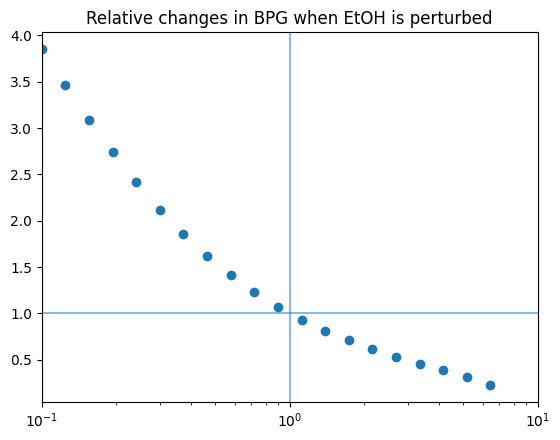

In [13]:
plt.scatter(EtOH_scale, calculate_relative_change('BPG'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in BPG when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

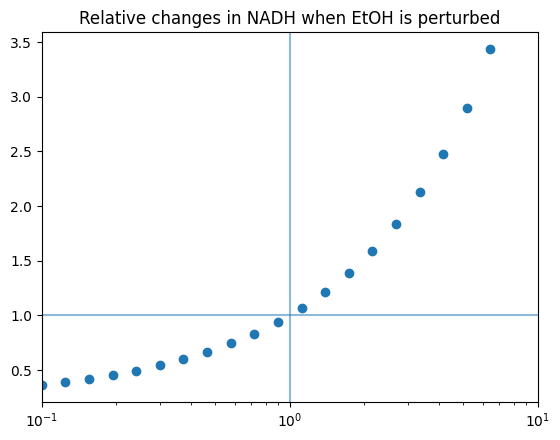

In [14]:
plt.scatter(EtOH_scale, calculate_relative_change('NADH'))
plt.xscale('log', base=10)
plt.xlim(0.1, 10)
plt.title('Relative changes in NADH when EtOH is perturbed')
plt.axvline(1, alpha=0.5)
plt.axhline(1, alpha=0.5)

## Plotting changes in steady state fluxes due to changes in boundary species using parameters derived from the model using tellurium

Plotting relative changes in EtOH by relative changes in steady state fluxes *when fully parameterized*

In [9]:
ETOH_data_file = '../data/generated_data/ogTeusink/EtOHcompilation.csv'
ETOH_data = pd.read_csv(ETOH_data_file)

Teusink_ant = '../models/Antimony/BIOMD0000000064_e.ant'
ref_idx=14

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis=True
BIOMD64 = antemll.antemll(Teusink_ant, ETOH_data_file, 
                          '../models/sbml/BIOMD64_cobra_sbml.xml', ref_ind=ref_idx)
r.steadyState()
Ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))

No objective coefficients in model. Unclear what should be optimized


../models/Antimony/BIOMD0000000064_e_cobra.ant


In [10]:
a = ETOH_data['ETOH']/50

In [11]:
real_ETOH_values = ETOH_data[[i for i in ETOH_data.columns if 'v_' in i]]
rel_real_ETOH_values = real_ETOH_values.div(real_ETOH_values.iloc[ref_idx])
# rel_real_ETOH_values.drop(rel_real_ETOH_values.index[0], inplace=True)
rel_real_ETOH_values.columns = r.getReactionIds()
rel_real_ETOH_values = rel_real_ETOH_values.transpose()
rel_real_ETOH_values.columns = a.round(2).values
rel_real_ETOH_values


0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    1.013158  1.009094  1.006402  1.004547  1.003245  1.002322  1.001665   
vPGI    1.014996  1.010364  1.007296  1.005182  1.003698  1.002646  1.001897   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    1.014996  1.010364  1.007296  1.005182  1.003698  1.002646  1.001897   
vALD    1.014996  1.010364  1.007296  1.005182  1.003698  1.002646  1.001897   
vGAPDH  1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPGK    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPGM    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vENO    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPYK    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vPDC    1.060226  1.039023  1.026441  1.018319  1.012855  1.009095  1.006468   
vSUC    0.675820  0.795449  0.863731  0.906671  0.935025  0.954292  0.967623   
vGLT    1.013158  1.009094  1.006402  1.004547  1.003245  1.002322  1.001665   
vADH    1.081886  1.052748  1.035609  1.024609  1.017241  1.012183  1.008657   
vG3PDH  0.675820  0.795449  0.863731  0.906671  0.935025  0.954292  0.967623   
vATP    1.222897  1.142294  1.095512  1.065753  1.045942  1.032401  1.022993   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    1.001195  1.000858  1.000617  1.000444  1.000319  1.000230  1.000165   
vPGI    1.001362  1.000978  1.000703  1.000506  1.000364  1.000262  1.000188   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    1.001362  1.000978  1.000703  1.000506  1.000364  1.000262  1.000188   
vALD    1.001362  1.000978  1.000703  1.000506  1.000364  1.000262  1.000188   
vGAPDH  1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPGK    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPGM    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vENO    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPYK    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vPDC    1.004616  1.003303  1.002367  1.001698  1.001220  1.000877  1.000630   
vSUC    0.976957  0.983547  0.988226  0.991560  0.993944  0.995650  0.996874   
vGLT    1.001195  1.000858  1.000617  1.000444  1.000319  1.000230  1.000165   
vADH    1.006175  1.004416  1.003164  1.002270  1.001630  1.001171  1.000842   
vG3PDH  0.976957  0.983547  0.988226  0.991560  0.993944  0.995650  0.996874   
vATP    1.016385  1.011710  1.008386  1.006014  1.004317  1.003101  1.002229   

        1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK     1.0  0.999835  0.999771  0.999682  0.999558  0.999387  0.999149   
vPGI     1.0  0.999812  0.999739  0.999638  0.999497  0.999301  0.999030   
vGLYCO   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK     1.0  0.999812  0.999739  0.999638  0.999497  0.999301  0.999030   
vALD     1.0  0.999812  0.999739  0.999638  0.999497  0.999301  0.999030   
vGAPDH   1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPGK     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPGM     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vENO     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPYK     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vPDC     1.0  0.999373  0.999130  0.998793  0.998327  0.997682  0.996791   
vSUC     1.0  1.003102  1.004304  1.005969  1.008270  1.011447  1.015821   
vGLT     1.0  0.999835  0.999771  0.999682  0.999558  0.999387  0.

In [12]:
fp_EtOH_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@(BIOMD64.xn).T + Ey@(BIOMD64.yn).T)

fp_EtOH_perturbed_fluxes_df = pd.DataFrame(fp_EtOH_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
fp_EtOH_perturbed_fluxes_df

0.28        0.48        0.63        0.73        0.81  \
vGLK     89.538829   89.050013   88.760670   88.573335   88.447078   
vPGI     81.687774   79.350710   78.429631   77.987394   77.748907   
vGLYCO    6.000000    6.000000    6.000000    6.000000    6.000000   
vTreha    2.400000    2.400000    2.400000    2.400000    2.400000   
vPFK     85.884403   81.272057   79.343759   78.434288   77.971321   
vALD     78.750360   78.223722   77.942235   77.762709   77.641283   
vGAPDH  146.909859  142.544569  140.401384  139.130150  138.314436   
vPGK    196.936942  161.597820  148.722038  143.006675  140.187006   
vPGM    147.365929  142.627279  140.418553  139.133106  138.314336   
vENO    148.366780  142.972531  140.560034  139.196316  138.344018   
vPYK    161.873917  148.038143  142.755787  140.214729  138.834678   
vPDC    145.490634  142.127439  140.240487  139.060332  138.282149   
vSUC      2.214017    2.807340    3.107146    3.283773    3.395877   
vGLT     89.412035   88.998271   88.736652   88.561620   88.441227   
vADH    182.909706  148.735545  138.734815  134.533238  132.432321   
vG3PDH   11.973299   14.378315   15.684271   16.487846   17.012633   
vATP    101.329766   95.691262   92.204250   89.897024   88.320518   

              0.86        0.90        0.93        0.95        0.96  \
vGLK     88.360065   88.299265   88.256397   88.225986   88.204322   
vPGI     77.609807   77.523996   77.468842   77.432302   77.407546   
vGLYCO    6.000000    6.000000    6.000000    6.000000    6.000000   
vTreha    2.400000    2.400000    2.400000    2.400000    2.400000   
vPFK     77.721826   77.580871   77.497877   77.447179   77.415188   
vALD     77.556976   77.497638   77.455545   77.425542   77.404091   
vGAPDH  137.768836  137.394888  137.134599  136.951536  136.821885   
vPGK    138.694566  137.859006  137.368830  137.070645  136.883373   
vPGM    137.768308  137.394454  137.134300  136.951356  136.821796   
vENO    137.782688  137.401569  137.137868  136.953160  136.822721   
vPYK    138.024682  137.522746  137.199168  136.984388  136.838706   
vPDC    137.753348  137.387272  137.130773  136.949596  136.820912   
vSUC      3.470128    3.520630    3.555582    3.580056    3.597332   
vGLT     88.357104   88.297755   88.255623   88.225588   88.204117   
vADH    131.264715  130.567865  130.130356  129.845371  129.654672   
vG3PDH   17.367039   17.611365   17.782065   17.902396   17.987741   
vATP     87.223682   86.452096   85.905434   85.516284   85.238365   

              0.97        0.98        0.99        0.99        1.00  \
vGLK     88.188844   88.177762   88.169816   88.164113   88.149527   
vPGI     77.390497   77.378612   77.370254   77.364338   77.349527   
vGLYCO    6.000000    6.000000    6.000000    6.000000    6.000000   
vTreha    2.400000    2.400000    2.400000    2.400000    2.400000   
vPFK     77.394427   77.380635   77.371295   77.364874   77.349527   
vALD     77.388724   77.377700   77.369784   77.364096   77.349527   
vGAPDH  136.729651  136.663831  136.616708  136.582952  136.496807   
vPGK    136.761577  136.679872  136.625442  136.587449  136.496807   
vPGM    136.729610  136.663796  136.616702  136.582951  136.496807   
vENO    136.730085  136.664042  136.616830  136.583012  136.496807   
vPYK    136.738296  136.668270  136.619010  136.584141  136.496807   
vPDC    136.729162  136.663569  136.616586  136.582889  136.496807   
vSUC      3.609595    3.618334    3.624580    3.629052    3.640449   
vGLT     88.188738   88.177707   88.169788   88.164098   88.149527   
vADH    129.524500  129.434359  129.371262  129.326759  129.215909   
vG3PDH   18.048530   18.091957   18.123046   18.145337   18.202246   
vATP     85.039436   84.896825   84.794472   84.720957   84.532764   

              1.01        1.01        1.02        1.03        1.04  \
vGLK     88.135024   88.129397   88.121598   88.110802   88.095874   
vPGI     77.335245   77.329822   77.322416   77.312370   77.298871   
vGLYCO    6.000000   

In [13]:
rel_fp_EtOH_perturbed_fluxes_df = fp_EtOH_perturbed_fluxes_df.div(fp_EtOH_perturbed_fluxes_df[1.00], axis=0)
# rel_fp_EtOH_perturbed_fluxes_df

In [14]:
vis_EtOH_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)

vis_EtOH_perturbed_fluxes_df = pd.DataFrame(vis_EtOH_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# vis_EtOH_perturbed_fluxes_df

In [15]:
vis_EtOH_perturbed_fluxes_df[1.00]

vGLK       88.149527
vPGI       77.349527
vGLYCO      6.000000
vTreha      2.400000
vPFK       77.349527
vALD       77.349527
vGAPDH    136.496807
vPGK      136.496807
vPGM      136.496807
vENO      136.496807
vPYK      136.496807
vPDC      136.496807
vSUC        3.640449
vGLT       88.149527
vADH      129.215909
vG3PDH     18.202246
vATP       84.532764
Name: 1.0, dtype: float64

In [16]:
rel_vis_EtOH_perturbed_fluxes_df = vis_EtOH_perturbed_fluxes_df.div(vis_EtOH_perturbed_fluxes_df[1.00], axis=0)
# rel_vis_EtOH_perturbed_fluxes_df

In [17]:
import pymc as pm
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [18]:
with pymc_model:
    
    # e_obs = pm.Normal('e_obs', mu=BIOMD64.en.T, sigma=0.1)
    chi_obs = BIOMD64.xn.T # pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = BIOMD64.yn.T# pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)

    likelihood = pm.Deterministic('vn', (np.ones((17,30)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries,
 Ex_capacity_entries,
 Ey_kinetic_entries,
 Ey_capacity_entries]

In [19]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n= N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = -153.92
Sampling: [v_hat_obs]


In [22]:
v_hat_obs_post = ppc_vi.posterior_predictive['v_hat_obs'].median(dim=['chain','draw'])
v_hat_obs_post_df = pd.DataFrame(np.array(v_hat_obs_post), index=r.getReactionIds(), columns=a.round(2).values)
v_hat_obs_post_df
# v_hat_obs_post_df.mul(BIOMD64.v_star, axis='rows')

0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    0.993229  0.988096  0.997758  0.992942  0.998936  1.001010  1.000615   
vPGI    1.054821  1.030574  1.012070  1.005204  1.004187  0.999562  1.006421   
vGLYCO  1.041040  1.028698  1.018969  1.008385  1.008646  1.007118  1.005351   
vTreha  1.044065  1.030058  1.018832  1.015222  1.015565  1.006685  1.003774   
vPFK    0.995510  1.011141  1.012009  1.009250  1.010532  1.002139  1.001077   
vALD    1.045985  1.024113  1.021839  1.017936  1.008997  1.006497  0.998792   
vGAPDH  1.014368  1.029850  1.023096  1.022502  1.012711  1.002068  1.005008   
vPGK    1.083162  1.050633  1.032184  1.021117  1.011638  1.006722  1.005638   
vPGM    1.059120  1.030613  1.019340  1.011039  1.000281  1.004036  1.000989   
vENO    1.099867  1.049959  1.029645  1.017231  1.017316  1.013003  1.011660   
vPYK    1.127818  1.056078  1.029067  1.009706  1.016112  1.007143  1.005498   
vPDC    1.096919  1.064593  1.043433  1.025724  1.019589  1.014970  1.010886   
vSUC    0.620057  0.796366  0.871798  0.915392  0.942449  0.966232  0.983386   
vGLT    1.028515  1.023514  1.021508  1.009196  1.005138  1.016144  1.002820   
vADH    1.197440  1.076438  1.044356  1.019360  1.021217  1.013506  1.007389   
vG3PDH  0.666193  0.810889  0.871961  0.907423  0.934388  0.961140  0.967729   
vATP    1.145789  1.094908  1.068077  1.048074  1.034093  1.024554  1.011277   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    0.998434  0.995144  0.999169  1.000853  0.999541  1.001879  0.996480   
vPGI    1.005502  1.004097  1.002130  1.001104  0.995507  0.996108  0.998937   
vGLYCO  1.002523  1.002157  1.003667  1.001125  1.003530  1.002700  0.997494   
vTreha  1.007075  1.004585  1.008069  1.006708  0.999922  0.998518  0.995603   
vPFK    1.003616  0.994877  1.000813  1.005323  1.002601  0.999869  0.997212   
vALD    1.004399  0.999649  0.997661  1.004326  1.005450  1.004181  1.001159   
vGAPDH  1.003860  0.999561  1.003580  0.998971  1.005241  0.997849  1.001943   
vPGK    1.005597  1.011323  1.002897  1.009830  0.999251  1.003057  1.000129   
vPGM    1.008232  1.005444  0.992087  1.000599  1.006611  1.000972  0.996573   
vENO    1.002264  1.008797  1.001865  0.998987  1.003964  0.999762  0.999470   
vPYK    1.005717  1.002132  0.993843  1.006813  0.997319  0.996251  1.002667   
vPDC    1.004915  1.004380  1.006881  0.998327  0.996476  1.001548  1.006279   
vSUC    0.989141  0.988517  0.989538  0.996677  0.992126  0.992314  1.001409   
vGLT    1.004958  1.000991  0.996356  0.999179  1.003273  0.997235  1.001379   
vADH    1.005289  1.004170  1.001137  1.003101  1.000138  1.000470  0.996730   
vG3PDH  0.981671  0.987381  0.984371  0.994829  0.994483  0.997091  1.000726   
vATP    1.012196  1.010883  1.006757  1.001618  1.007520  1.008474  0.999732   

            1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK    0.997311  1.003467  1.001781  1.001399  0.999159  1.001733  0.992704   
vPGI    0.997632  0.993605  0.996390  0.998360  0.997575  0.996445  1.001340   
vGLYCO  0.996329  1.003714  0.998179  1.005130  1.001929  1.003083  0.993997   
vTreha  0.997555  0.998845  1.000246  1.002000  1.003839  1.007361  0.990921   
vPFK    0.988519  0.997858  0.999152  1.003611  0.997966  0.999288  1.003928   
vALD    1.002562  1.001408  0.999723  0.999790  1.000398  1.002049  0.995219   
vGAPDH  1.002972  1.004743  0.996451  0.998374  0.998652  0.999668  0.997380   
vPGK    1.004095  1.002067  0.997540  0.988675  0.993319  0.994023  0.992659   
vPGM    1.001314  1.002682  1.003894  0.995535  1.001728  0.991760  0.993292   
vENO    0.998825  1.001878  0.998722  1.001999  0.992507  0.993547  0.989674   
vPYK    0.996809  1.003699  1.003754  0.995083  0.995378  0.995812  0.997959   
vPDC    1.005298  1.001683  1.003642  1.009012  1.001869  0.998334  0.995548   
vSUC    0.996341  1.004378  1.011272  1.000028  1.002142  1.014636  1.020261   
vGLT    1.

Text(0, 0.5, 'median posterior predictive flux values')

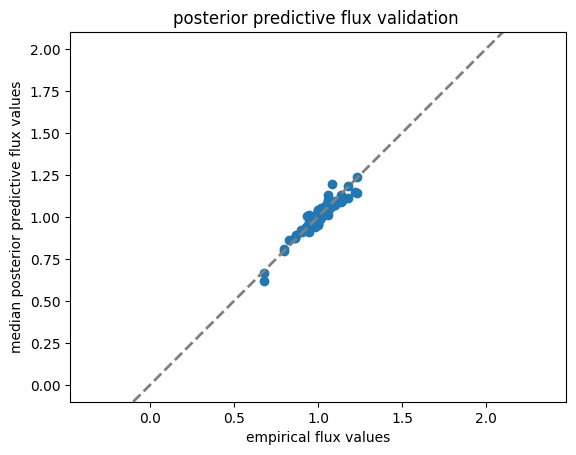

In [30]:
plt.scatter(BIOMD64.vn, v_hat_obs_post_df.transpose())
plt.axis('equal')
plt.axline([0, 0], [2, 2], c='gray', linestyle='dashed', linewidth=2)

plt.title('posterior predictive flux validation ')
plt.xlabel('empirical flux values')
plt.ylabel('median posterior predictive flux values')

In [94]:
fp_EtOH_perturbed_fluxes_df

0.28        0.48        0.63        0.73        0.81  \
vGLK     89.538829   89.050013   88.760670   88.573335   88.447078   
vPGI     81.687774   79.350710   78.429631   77.987394   77.748907   
vGLYCO    6.000000    6.000000    6.000000    6.000000    6.000000   
vTreha    2.400000    2.400000    2.400000    2.400000    2.400000   
vPFK     85.884403   81.272057   79.343759   78.434288   77.971321   
vALD     78.750360   78.223722   77.942235   77.762709   77.641283   
vGAPDH  146.909859  142.544569  140.401384  139.130150  138.314436   
vPGK    196.936942  161.597820  148.722038  143.006675  140.187006   
vPGM    147.365929  142.627279  140.418553  139.133106  138.314336   
vENO    148.366780  142.972531  140.560034  139.196316  138.344018   
vPYK    161.873917  148.038143  142.755787  140.214729  138.834678   
vPDC    145.490634  142.127439  140.240487  139.060332  138.282149   
vSUC      2.214017    2.807340    3.107146    3.283773    3.395877   
vGLT     89.412035   88.998271   88.736652   88.561620   88.441227   
vADH    182.909706  148.735545  138.734815  134.533238  132.432321   
vG3PDH   11.973299   14.378315   15.684271   16.487846   17.012633   
vATP    101.329766   95.691262   92.204250   89.897024   88.320518   

              0.86        0.90        0.93        0.95        0.96  \
vGLK     88.360065   88.299265   88.256397   88.225986   88.204322   
vPGI     77.609807   77.523996   77.468842   77.432302   77.407546   
vGLYCO    6.000000    6.000000    6.000000    6.000000    6.000000   
vTreha    2.400000    2.400000    2.400000    2.400000    2.400000   
vPFK     77.721826   77.580871   77.497877   77.447179   77.415188   
vALD     77.556976   77.497638   77.455545   77.425542   77.404091   
vGAPDH  137.768836  137.394888  137.134599  136.951536  136.821885   
vPGK    138.694566  137.859006  137.368830  137.070645  136.883373   
vPGM    137.768308  137.394454  137.134300  136.951356  136.821796   
vENO    137.782688  137.401569  137.137868  136.953160  136.822721   
vPYK    138.024682  137.522746  137.199168  136.984388  136.838706   
vPDC    137.753348  137.387272  137.130773  136.949596  136.820912   
vSUC      3.470128    3.520630    3.555582    3.580056    3.597332   
vGLT     88.357104   88.297755   88.255623   88.225588   88.204117   
vADH    131.264715  130.567865  130.130356  129.845371  129.654672   
vG3PDH   17.367039   17.611365   17.782065   17.902396   17.987741   
vATP     87.223682   86.452096   85.905434   85.516284   85.238365   

              0.97        0.98        0.99        0.99        1.00  \
vGLK     88.188844   88.177762   88.169816   88.164113   88.149527   
vPGI     77.390497   77.378612   77.370254   77.364338   77.349527   
vGLYCO    6.000000    6.000000    6.000000    6.000000    6.000000   
vTreha    2.400000    2.400000    2.400000    2.400000    2.400000   
vPFK     77.394427   77.380635   77.371295   77.364874   77.349527   
vALD     77.388724   77.377700   77.369784   77.364096   77.349527   
vGAPDH  136.729651  136.663831  136.616708  136.582952  136.496807   
vPGK    136.761577  136.679872  136.625442  136.587449  136.496807   
vPGM    136.729610  136.663796  136.616702  136.582951  136.496807   
vENO    136.730085  136.664042  136.616830  136.583012  136.496807   
vPYK    136.738296  136.668270  136.619010  136.584141  136.496807   
vPDC    136.729162  136.663569  136.616586  136.582889  136.496807   
vSUC      3.609595    3.618334    3.624580    3.629052    3.640449   
vGLT     88.188738   88.177707   88.169788   88.164098   88.149527   
vADH    129.524500  129.434359  129.371262  129.326759  129.215909   
vG3PDH   18.048530   18.091957   18.123046   18.145337   18.202246   
vATP     85.039436   84.896825   84.794472   84.720957   84.532764   

              1.01        1.01        1.02        1.03        1.04  \
vGLK     88.135024   88.129397   88.121598   88.110802   88.095874   
vPGI     77.335245   77.329822   77.322416   77.312370   77.298871   
vGLYCO    6.000000   

In [65]:
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))

# these are the elasticity posteriors from Bayesian inference
EtOH_BI_Ex = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
EtOH_BI_Ex[abs(EtOH_BI_Ex) < 0.01] = 0

EtOH_BI_Ex = EtOH_BI_Ex.reshape((17,14))
pd.DataFrame(EtOH_BI_Ex, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())



P       G6P      TRIO       NAD       ACE       P2G       BPG  \
vGLK    1.167684 -0.124263 -0.012007  0.000000 -0.011067  0.000000  0.000000   
vPGI    0.000000  0.691832  0.000000  0.000000  0.000000  0.000000  0.000000   
vGLYCO  0.461915  0.035096  0.000000  0.000000  0.000000  0.000000  0.000000   
vTreha  0.426114  0.046591  0.000000  0.000000  0.000000  0.000000  0.000000   
vPFK    0.676880  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
vALD    0.000000  0.000000 -0.909376  0.000000  0.000000  0.000000  0.000000   
vGAPDH  0.000000  0.000000  0.765442  1.161196  0.000000  0.000000 -0.525366   
vPGK   -0.954159  0.000000  0.000000  0.000000  0.000000  0.000000  0.506106   
vPGM    0.000000  0.000000  0.000000  0.000000  0.000000 -0.893317  0.000000   
vENO    0.000000  0.000000  0.000000  0.000000  0.000000  0.811203  0.000000   
vPYK   -0.847505  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
vPDC    0.000000  0.000000  0.000000  0.000000 -0.135000  0.000000  0.000000   
vSUC    0.728174  0.000000  0.000000  0.690422  1.649643  0.000000  0.000000   
vGLT    0.000000  0.000000  0.000000  0.000000  0.010258 -0.011647  0.000000   
vADH    0.000000  0.000000  0.000000 -1.267550  1.494439  0.000000  0.000000   
vG3PDH  0.000000 -0.012224  1.213867 -1.133529  0.000000  0.000000  0.000000   
vATP    1.185577  0.000000  0.000000  0.000000  0.000000  0.000000  0.010296   

            GLCi       F6P       PEP       PYR      F16P       P3G      NADH  
vGLK    0.526859  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
vPGI    0.000000 -0.401214  0.000000  0.000000  0.000000  0.000000  0.000000  
vGLYCO  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
vTreha  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.011256  
vPFK    0.000000  0.125157  0.000000  0.000000 -0.868203  0.000000  0.000000  
vALD    0.000000  0.000000  0.000000  0.000000  1.083738  0.000000  0.000000  
vGAPDH -0.010677  0.000000  0.000000  0.000000  0.000000  0.000000 -0.597085  
vPGK    0.000000  0.000000  0.000000 -0.011986  0.000000 -0.599637  0.000000  
vPGM    0.000000  0.000000  0.000000  0.000000  0.000000  1.202672  0.000000  
vENO    0.000000  0.000000 -0.399218  0.000000  0.000000  0.000000 -0.010083  
vPYK    0.000000  0.000000  0.551622 -0.613609  0.000000  0.000000  0.000000  
vPDC    0.000000  0.000000  0.000000  0.428071  0.000000  0.000000  0.000000  
vSUC    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000 -0.283461  
vGLT   -0.330101  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
vADH    0.000000  0.000000  0.000000  0.000000  0.012487  0.000000  0.649114  
vG3PDH  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.643123  
vATP    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

In [66]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))

# elasticities from Bayesian inf posteriors

EtOH_BI_Ey = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
EtOH_BI_Ey[abs(EtOH_BI_Ey) < 0.01] = 0

EtOH_BI_Ey = EtOH_BI_Ey.reshape((17,5))
pd.DataFrame(EtOH_BI_Ey, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())

CO2      GLCo      ETOH       GLY     F26BP
vGLK    0.000000  0.000000  0.000000  0.000000  0.000000
vPGI    0.000000  0.000000  0.000000  0.000000  0.000000
vGLYCO  0.000000  0.000000  0.000000  0.000000  0.000000
vTreha  0.000000  0.000000  0.000000  0.000000  0.000000
vPFK    0.000000  0.000000  0.000000  0.000000  0.000000
vALD    0.000000  0.000000  0.000000  0.000000  0.000000
vGAPDH  0.000000  0.000000  0.000000  0.000000  0.000000
vPGK    0.000000  0.000000  0.000000  0.000000  0.000000
vPGM    0.000000  0.000000  0.000000  0.000000  0.000000
vENO    0.000000  0.000000  0.000000  0.000000 -0.012949
vPYK    0.000000  0.000000  0.000000  0.000000  0.000000
vPDC   -2.241691  0.000000  0.011283  0.000000  0.000000
vSUC    0.000000  0.000000  0.000000  0.000000  0.000000
vGLT    0.000000 -1.195205  0.012765  0.000000  0.000000
vADH    0.000000 -0.010233 -0.914898  0.000000  0.011159
vG3PDH  0.000000  0.000000  0.000000 -0.816973  0.000000
vATP    0.000000  0.000000  0.000000  0.000000  0.000000

In [67]:
# ETOH_BIpost_df is the flux calculated using the Bayesian inference POSTERIORS for elasticity
ETOH_BIpost = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + EtOH_BI_Ex@(BIOMD64.xn).T + EtOH_BI_Ey@(BIOMD64.yn).T)
ETOH_BIpost_df = pd.DataFrame(ETOH_BIpost) #, index=r.getReactionIds(), columns=a.round(2).values) 
ETOH_BIpost_df.index = r.getReactionIds()
ETOH_BIpost_df.columns = a.round(2).values
ETOH_BIpost_df = ETOH_BIpost_df.divide(ETOH_BIpost_df[1.00], axis=0)
ETOH_BIpost_df

0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    0.980000  0.989136  0.993412  0.995760  0.997170  0.998067  0.998659   
vPGI    1.040769  1.019992  1.011346  1.006975  1.004507  1.003009  1.002054   
vGLYCO  1.064545  1.041892  1.028443  1.019738  1.013869  1.009821  1.006989   
vTreha  1.057837  1.037517  1.025456  1.017658  1.012404  1.008781  1.006248   
vPFK    1.013829  1.018627  1.015158  1.011407  1.008377  1.006092  1.004410   
vALD    1.085085  1.048236  1.030820  1.020675  1.014228  1.009940  1.007010   
vGAPDH  1.049704  1.039173  1.028670  1.020671  1.014850  1.010660  1.007655   
vPGK    1.097827  1.051833  1.031024  1.019784  1.013110  1.008909  1.006157   
vPGM    1.062873  1.035425  1.022549  1.015094  1.010372  1.007239  1.005102   
vENO    1.080915  1.044294  1.027860  1.018540  1.012700  1.008848  1.006229   
vPYK    1.116610  1.051999  1.027870  1.016424  1.010269  1.006683  1.004474   
vPDC    1.107143  1.065607  1.043067  1.029255  1.020266  1.014212  1.010046   
vSUC    0.624152  0.792203  0.871608  0.916176  0.943481  0.961105  0.972868   
vGLT    1.040907  1.029923  1.021453  1.015354  1.010998  1.007887  1.005661   
vADH    1.148867  1.063274  1.035250  1.021891  1.014368  1.009735  1.006727   
vG3PDH  0.675116  0.796222  0.864606  0.907363  0.935527  0.954647  0.967873   
vATP    1.139113  1.091744  1.062859  1.043868  1.030938  1.021962  1.015656   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    0.999059  0.999335  0.999528  0.999663  0.999759  0.999827  0.999876   
vPGI    1.001424  1.000998  1.000705  1.000500  1.000357  1.000255  1.000182   
vGLYCO  1.004991  1.003572  1.002561  1.001838  1.001320  1.000949  1.000682   
vTreha  1.004461  1.003193  1.002289  1.001643  1.001180  1.000848  1.000610   
vPFK    1.003185  1.002297  1.001656  1.001193  1.000859  1.000618  1.000445   
vALD    1.004974  1.003545  1.002533  1.001814  1.001301  1.000934  1.000671   
vGAPDH  1.005500  1.003953  1.002841  1.002043  1.001470  1.001057  1.000760   
vPGK    1.004305  1.003035  1.002153  1.001534  1.001095  1.000785  1.000562   
vPGM    1.003619  1.002578  1.001842  1.001319  1.000946  1.000679  1.000488   
vENO    1.004415  1.003144  1.002246  1.001608  1.001153  1.000827  1.000594   
vPYK    1.003056  1.002118  1.001483  1.001047  1.000743  1.000529  1.000378   
vPDC    1.007140  1.005093  1.003642  1.002610  1.001872  1.001344  1.000966   
vSUC    0.980898  0.986465  0.990367  0.993122  0.995078  0.996472  0.997468   
vGLT    1.004066  1.002922  1.002101  1.001511  1.001087  1.000782  1.000563   
vADH    1.004707  1.003322  1.002358  1.001681  1.001201  1.000860  1.000617   
vG3PDH  0.977134  0.983672  0.988314  0.991623  0.993989  0.995682  0.996897   
vATP    1.011193  1.008018  1.005751  1.004129  1.002967  1.002132  1.001533   

        1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK     1.0  1.000122  1.000168  1.000233  1.000322  1.000443  1.000608   
vPGI     1.0  0.999822  0.999754  0.999661  0.999533  0.999360  0.999127   
vGLYCO   1.0  0.999322  0.999058  0.998693  0.998188  0.997489  0.996523   
vTreha   1.0  0.999394  0.999158  0.998832  0.998381  0.997756  0.996893   
vPFK     1.0  0.999554  0.999380  0.999139  0.998803  0.998335  0.997685   
vALD     1.0  0.999335  0.999078  0.998722  0.998230  0.997552  0.996620   
vGAPDH   1.0  0.999241  0.998946  0.998535  0.997965  0.997176  0.996080   
vPGK     1.0  0.999449  0.999236  0.998946  0.998547  0.998000  0.997261   
vPGM     1.0  0.999517  0.999330  0.999071  0.998714  0.998222  0.997545   
vENO     1.0  0.999412  0.999184  0.998869  0.998434  0.997835  0.997012   
vPYK     1.0  0.999636  0.999498  0.999310  0.999054  0.998712  0.998259   
vPDC     1.0  0.999042  0.998671  0.998158  0.997449  0.996470  0.995124   
vSUC     1.0  1.002494  1.003456  1.004783  1.006609  1.009113  1.012530   
vGLT     1.0  0.999438  0.999220  0.998916  0.998495  0.997910  0.

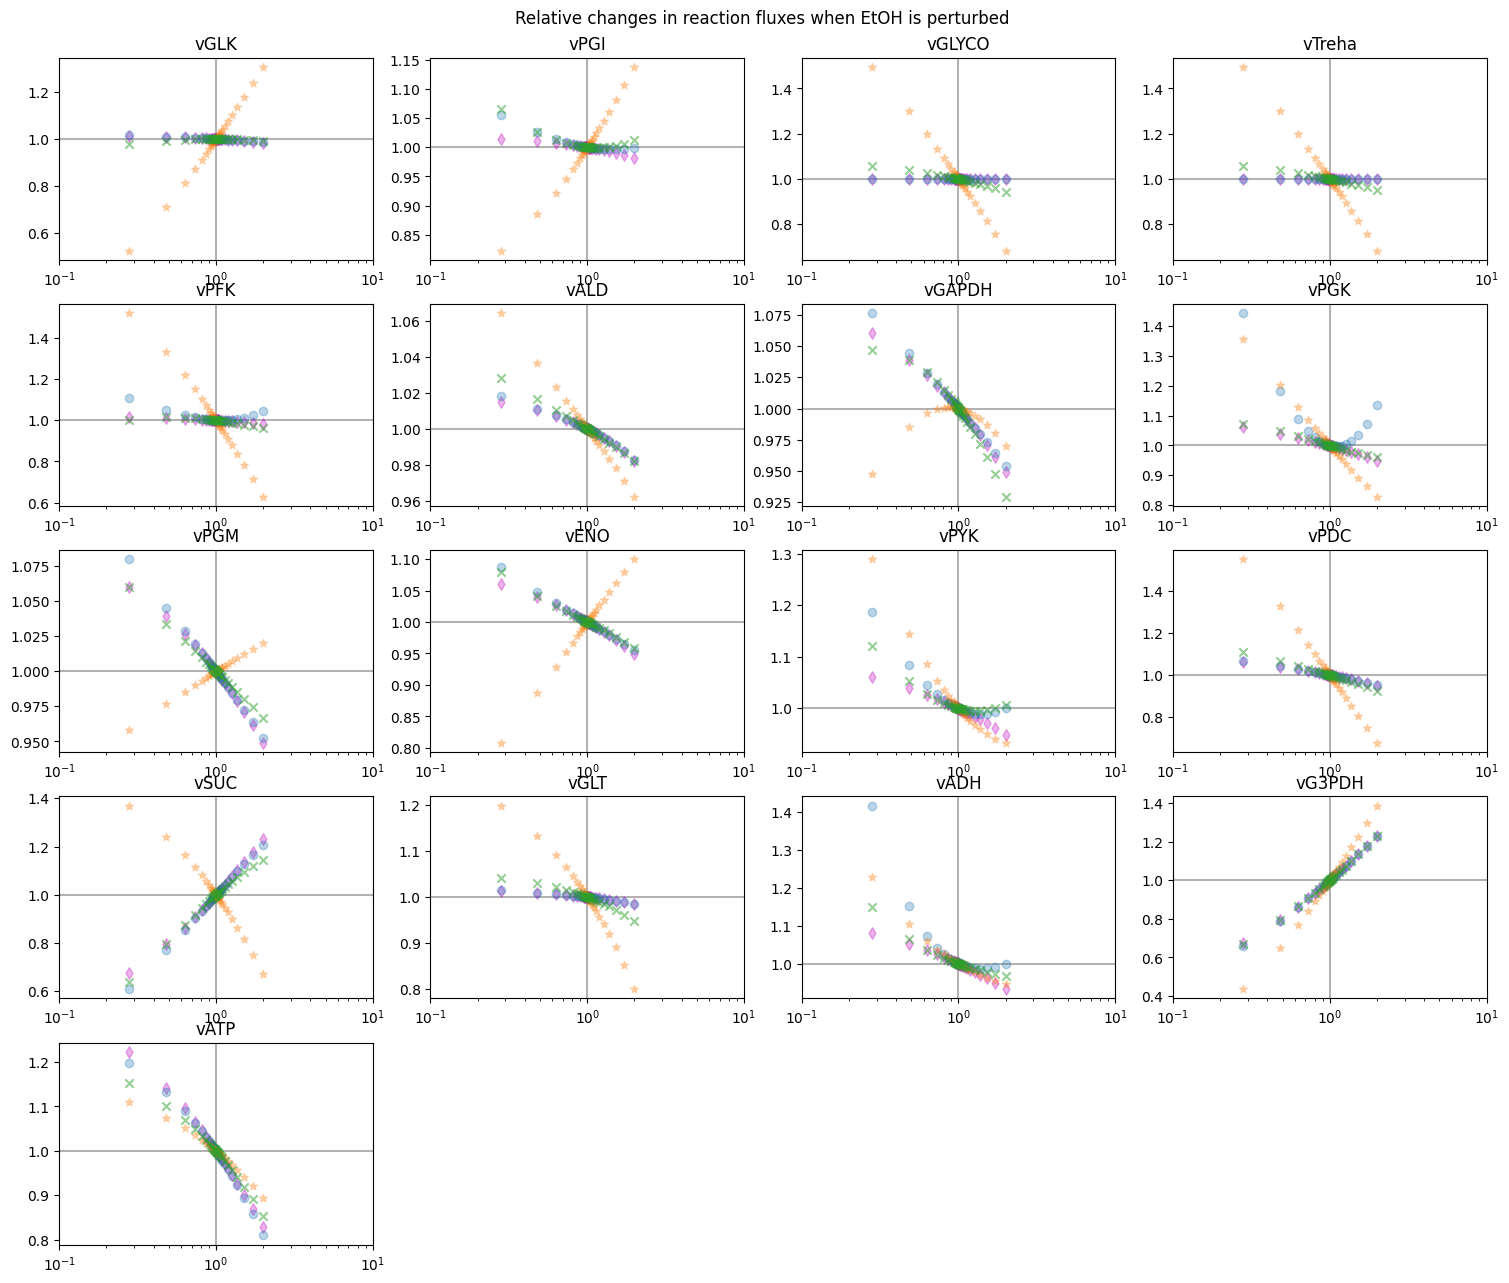

In [29]:
fig, axs = plt.subplots(5,4, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when EtOH is perturbed\n')
fig.tight_layout()

for i, rxn in enumerate(r.getReactionIds()):
  if i%4==0:
    idx_starter += 1
  
  axs[idx_starter, i%4].scatter(rel_real_ETOH_values.columns, rel_real_ETOH_values.loc[rxn], alpha=0.3, c='m', marker='d')
  axs[idx_starter, i%4].scatter(rel_fp_EtOH_perturbed_fluxes_df.columns, rel_fp_EtOH_perturbed_fluxes_df.loc[rxn], alpha=0.3)
  axs[idx_starter, i%4].scatter(rel_vis_EtOH_perturbed_fluxes_df.columns, rel_vis_EtOH_perturbed_fluxes_df.loc[rxn], alpha=0.3, marker='*')
  axs[idx_starter, i%4].scatter(ETOH_BIpost_df.columns, ETOH_BIpost_df.loc[rxn], alpha=0.5, marker='x')
  
  axs[idx_starter, i%4].set_xscale('log', base=10)
  axs[idx_starter, i%4].set_xlim([0.1, 10])
  axs[idx_starter, i%4].set_title(rxn)
  axs[idx_starter, i%4].axvline(1, alpha=0.3, color='k', zorder=0)
  axs[idx_starter, i%4].axhline(1, alpha=0.3, color='k', zorder=0)

fig.delaxes(axs[4,1]) 
fig.delaxes(axs[4,2]) 
fig.delaxes(axs[4,3]) 

# plt.legend(["real values", "fully parameterized", "BI priors", "BI posteriors"])
plt.show()

Plotting relative changes in GLY by relative changes in steady state fluxes *when fully parameterized*

In [ ]:
GLY_data_file = 'data/interim/generated_data/GLYcompilation.csv'
GLY_data = pd.read_csv(GLY_data_file)

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
r = te.loada(Teusink_ant)
BIOMD64 = antemll.antemll(Teusink_ant, GLY_data_file)
r.steadyState()
Ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [31]:
a = GLY_data['GLY']/0.15
a.drop(a.index[0],inplace=True)

fp_GLY_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@(BIOMD64.xn).T + Ey@(BIOMD64.yn).T)

fp_GLY_perturbed_fluxes_df = pd.DataFrame(fp_GLY_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# fp_GLY_perturbed_fluxes_df

In [32]:
fp_rel_GLY_perturbed_fluxes_df = fp_GLY_perturbed_fluxes_df.div(fp_GLY_perturbed_fluxes_df[1.00], axis=0)
# fp_rel_GLY_perturbed_fluxes_df

In [33]:
vis_GLY_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)

vis_GLY_perturbed_fluxes_df = pd.DataFrame(vis_GLY_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# vis_GLY_perturbed_fluxes_df

In [34]:
vis_rel_GLY_perturbed_fluxes_df = vis_GLY_perturbed_fluxes_df.div(vis_GLY_perturbed_fluxes_df[1.00], axis=0)
# vis_rel_GLY_perturbed_fluxes_df

In [35]:
real_GLY_values = GLY_data[[i for i in GLY_data.columns if 'v_' in i]]
rel_real_GLY_values = real_GLY_values.div(real_GLY_values.iloc[0])
rel_real_GLY_values.drop(rel_real_GLY_values.index[0], inplace=True)
rel_real_GLY_values.columns = r.getReactionIds()
rel_real_GLY_values = rel_real_GLY_values.transpose()
rel_real_GLY_values.columns = a.round(2).values
rel_real_GLY_values


0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    0.998869  0.999198  0.999429  0.999593  0.999708  0.999791  0.999850   
vPGI    0.998711  0.999086  0.999350  0.999536  0.999668  0.999762  0.999829   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    0.998711  0.999086  0.999350  0.999536  0.999668  0.999762  0.999829   
vALD    0.998711  0.999086  0.999350  0.999536  0.999668  0.999762  0.999829   
vGAPDH  0.995732  0.996964  0.997833  0.998449  0.998889  0.999203  0.999427   
vPGK    0.995732  0.996964  0.997833  0.998449  0.998889  0.999203  0.999427   
vPGM    0.995732  0.996964  0.997833  0.998449  0.998889  0.999203  0.999427   
vENO    0.995732  0.996964  0.997833  0.998449  0.998889  0.999203  0.999427   
vPYK    0.995732  0.996964  0.997833  0.998449  0.998889  0.999203  0.999427   
vPDC    0.995732  0.996964  0.997833  0.998449  0.998889  0.999203  0.999427   
vSUC    1.021052  1.015006  1.010726  1.007682  1.005509  1.003955  1.002841   
vGLT    0.998869  0.999198  0.999429  0.999593  0.999708  0.999791  0.999850   
vADH    0.994305  0.995947  0.997106  0.997929  0.998516  0.998935  0.999235   
vG3PDH  1.021052  1.015006  1.010726  1.007682  1.005509  1.003955  1.002841   
vATP    0.984948  0.989281  0.992343  0.994519  0.996070  0.997180  0.997974   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    0.999892  0.999923  0.999944  0.999960  0.999971  0.999979  0.999985   
vPGI    0.999877  0.999912  0.999937  0.999954  0.999967  0.999976  0.999983   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    0.999877  0.999912  0.999937  0.999954  0.999967  0.999976  0.999983   
vALD    0.999877  0.999912  0.999937  0.999954  0.999967  0.999976  0.999983   
vGAPDH  0.999589  0.999704  0.999787  0.999847  0.999890  0.999921  0.999943   
vPGK    0.999589  0.999704  0.999787  0.999847  0.999890  0.999921  0.999943   
vPGM    0.999589  0.999704  0.999787  0.999847  0.999890  0.999921  0.999943   
vENO    0.999589  0.999704  0.999787  0.999847  0.999890  0.999921  0.999943   
vPYK    0.999589  0.999704  0.999787  0.999847  0.999890  0.999921  0.999943   
vPDC    0.999589  0.999704  0.999787  0.999847  0.999890  0.999921  0.999943   
vSUC    1.002042  1.001468  1.001056  1.000760  1.000547  1.000393  1.000283   
vGLT    0.999892  0.999923  0.999944  0.999960  0.999971  0.999979  0.999985   
vADH    0.999450  0.999605  0.999716  0.999796  0.999853  0.999894  0.999924   
vG3PDH  1.002042  1.001468  1.001056  1.000760  1.000547  1.000393  1.000283   
vATP    0.998544  0.998953  0.999247  0.999459  0.999610  0.999720  0.999798   

        1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK     1.0  1.000015  1.000021  1.000029  1.000040  1.000055  1.000077   
vPGI     1.0  1.000017  1.000024  1.000033  1.000045  1.000063  1.000088   
vGLYCO   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK     1.0  1.000017  1.000024  1.000033  1.000045  1.000063  1.000088   
vALD     1.0  1.000017  1.000024  1.000033  1.000045  1.000063  1.000088   
vGAPDH   1.0  1.000057  1.000079  1.000110  1.000153  1.000212  1.000294   
vPGK     1.0  1.000057  1.000079  1.000110  1.000153  1.000212  1.000294   
vPGM     1.0  1.000057  1.000079  1.000110  1.000153  1.000212  1.000294   
vENO     1.0  1.000057  1.000079  1.000110  1.000153  1.000212  1.000294   
vPYK     1.0  1.000057  1.000079  1.000110  1.000153  1.000212  1.000294   
vPDC     1.0  1.000057  1.000079  1.000110  1.000153  1.000212  1.000294   
vSUC     1.0  0.999717  0.999607  0.999454  0.999242  0.998948  0.998539   
vGLT     1.0  1.000015  1.000021  1.000029  1.000040  1.000055  1.

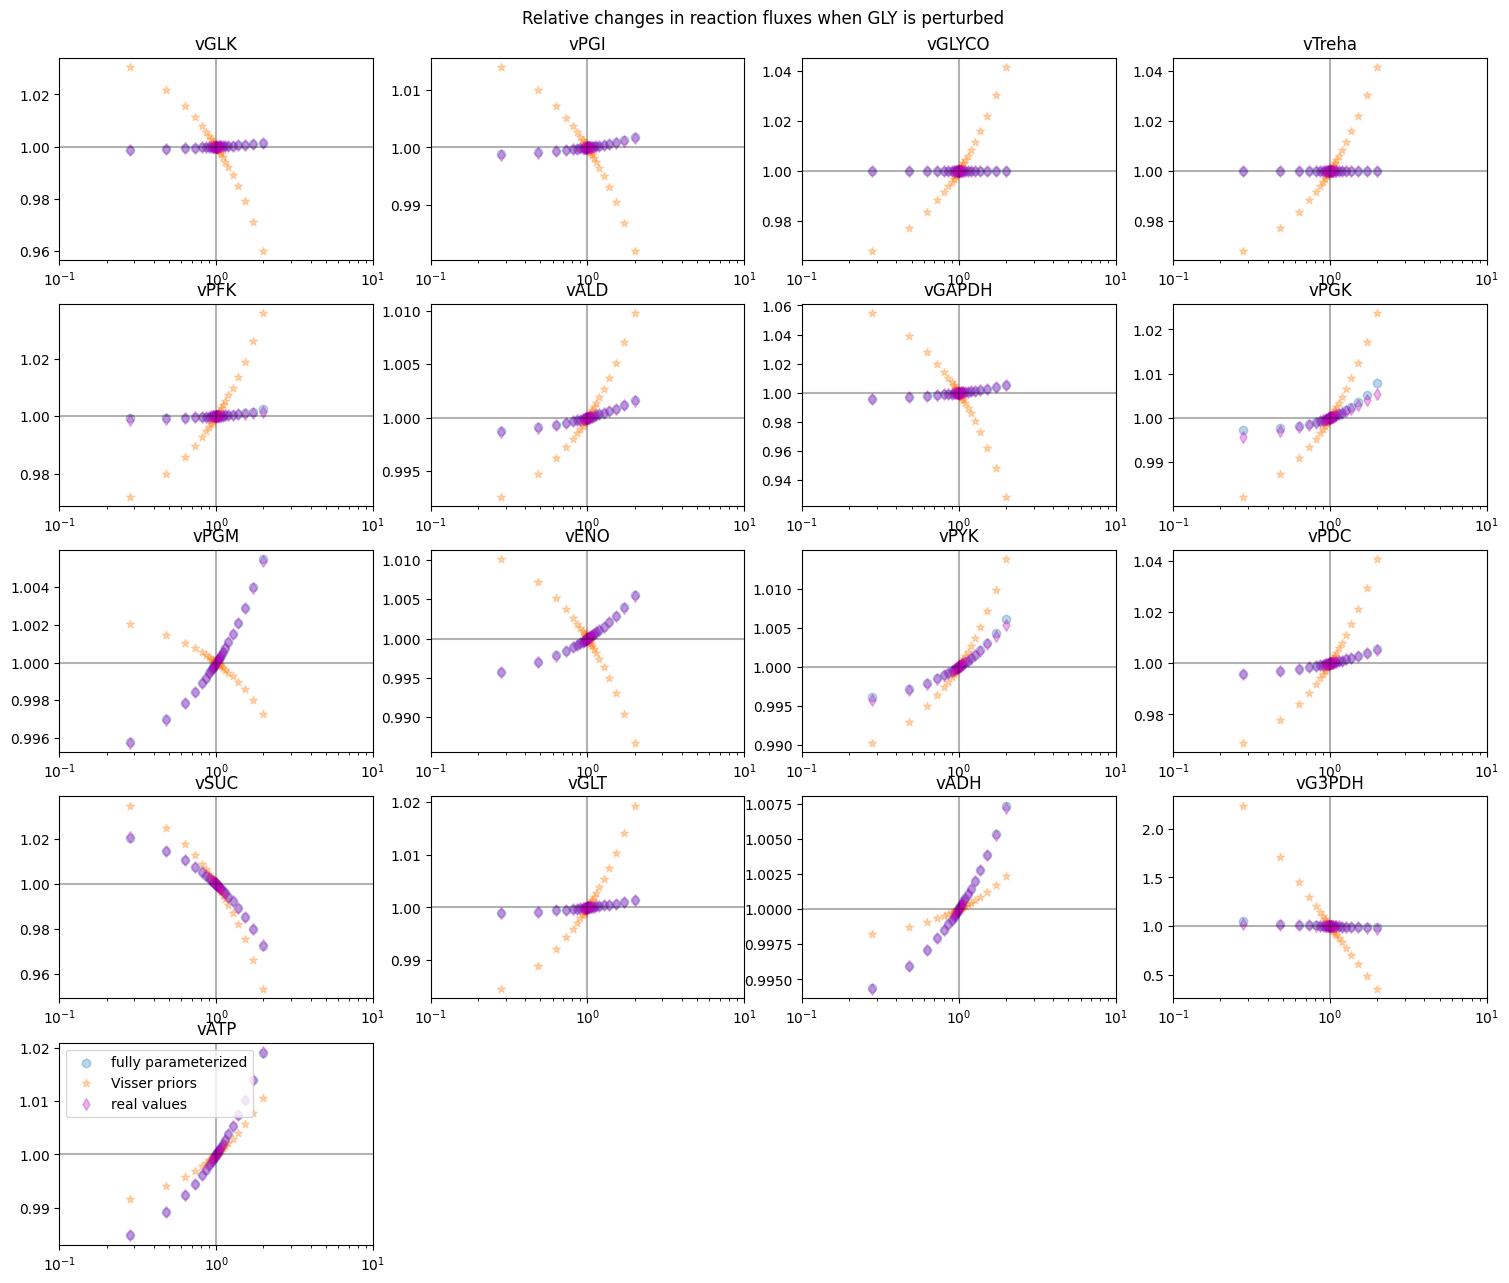

In [36]:
fig, axs = plt.subplots(5,4, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when GLY is perturbed\n')
fig.tight_layout()

for i, rxn in enumerate(r.getReactionIds()):
  if i%4==0:
    idx_starter += 1
  
  axs[idx_starter, i%4].scatter(fp_rel_GLY_perturbed_fluxes_df.columns, fp_rel_GLY_perturbed_fluxes_df.loc[rxn], alpha=0.3)
  axs[idx_starter, i%4].scatter(vis_rel_GLY_perturbed_fluxes_df.columns, vis_rel_GLY_perturbed_fluxes_df.loc[rxn], alpha=0.3, marker='*')
  axs[idx_starter, i%4].scatter(rel_real_GLY_values.columns, rel_real_GLY_values.loc[rxn], alpha=0.3, c='m', marker='d')
  axs[idx_starter, i%4].set_xscale('log', base=10)
  axs[idx_starter, i%4].set_xlim([0.1, 10])
  axs[idx_starter, i%4].set_title(rxn)
  axs[idx_starter, i%4].axvline(1, alpha=0.3, c='k')
  axs[idx_starter, i%4].axhline(1, alpha=0.3, c='k')

fig.delaxes(axs[4,1]) 
fig.delaxes(axs[4,2]) 
fig.delaxes(axs[4,3]) 

plt.legend(["fully parameterized", "Visser priors", "real values"])
plt.show()

Plotting relative changes in GLCo by relative changes in steady state fluxes *when fully parameterized*

In [ ]:
GLCo_data_file = 'data/interim/generated_data/GLCocompilation.csv'
GLCo_data = pd.read_csv(GLCo_data_file)

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
r = te.loada(Teusink_ant)
BIOMD64 = antemll.antemll(Teusink_ant, GLCo_data_file)
r.steadyState()
Ex = r.getScaledElasticityMatrix()
a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [38]:
a = GLCo_data['GLCo']/50
a.drop(a.index[0],inplace=True)

fp_GLCo_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + Ex@(BIOMD64.xn).T + Ey@(BIOMD64.yn).T)

fp_GLCo_perturbed_fluxes_df = pd.DataFrame(fp_GLCo_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# GLCo_perturbed_fluxes_df

In [39]:
fp_rel_GLCo_perturbed_fluxes_df = fp_GLCo_perturbed_fluxes_df.div(fp_GLCo_perturbed_fluxes_df[1.00], axis=0)
# fp_rel_GLCo_perturbed_fluxes_df

In [40]:
vis_GLCo_perturbed_fluxes = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)

vis_GLCo_perturbed_fluxes_df = pd.DataFrame(vis_GLCo_perturbed_fluxes.values, index=r.getReactionIds(), columns=a.round(2).values) 
# vis_GLCo_perturbed_fluxes_df

In [41]:
vis_rel_GLCo_perturbed_fluxes_df = vis_GLCo_perturbed_fluxes_df.div(vis_GLCo_perturbed_fluxes_df[1.00], axis=0)
# vis_rel_GLCo_perturbed_fluxes_df

In [42]:
real_GLCo_values = GLCo_data[[i for i in GLCo_data.columns if 'v_' in i]]
rel_real_GLCo_values = real_GLCo_values.div(real_GLCo_values.iloc[0])
rel_real_GLCo_values.drop(rel_real_GLCo_values.index[0], inplace=True)
rel_real_GLCo_values.columns = r.getReactionIds()
rel_real_GLCo_values = rel_real_GLCo_values.transpose()
rel_real_GLCo_values.columns = a.round(2).values
rel_real_GLCo_values


0.28      0.48      0.63      0.73      0.81      0.86      0.90  \
vGLK    0.939113  0.973712  0.985311  0.990894  0.994041  0.995974  0.997225   
vPGI    0.930612  0.970042  0.983260  0.989622  0.993209  0.995412  0.996838   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    0.930612  0.970042  0.983260  0.989622  0.993209  0.995412  0.996838   
vALD    0.930612  0.970042  0.983260  0.989622  0.993209  0.995412  0.996838   
vGAPDH  0.926153  0.968125  0.982192  0.988961  0.992777  0.995120  0.996636   
vPGK    0.926153  0.968125  0.982192  0.988961  0.992777  0.995120  0.996636   
vPGM    0.926153  0.968125  0.982192  0.988961  0.992777  0.995120  0.996636   
vENO    0.926153  0.968125  0.982192  0.988961  0.992777  0.995120  0.996636   
vPYK    0.926153  0.968125  0.982192  0.988961  0.992777  0.995120  0.996636   
vPDC    0.926153  0.968125  0.982192  0.988961  0.992777  0.995120  0.996636   
vSUC    0.964052  0.984413  0.991269  0.994580  0.996450  0.997600  0.998345   
vGLT    0.939113  0.973712  0.985311  0.990894  0.994041  0.995974  0.997225   
vADH    0.924017  0.967207  0.981680  0.988645  0.992570  0.994980  0.996540   
vG3PDH  0.964052  0.984413  0.991269  0.994580  0.996450  0.997600  0.998345   
vATP    0.894690  0.954572  0.974629  0.984276  0.989712  0.993051  0.995210   

            0.93      0.95      0.96      0.97      0.98      0.99      0.99  \
vGLK    0.998062  0.998634  0.999031  0.999310  0.999507  0.999647  0.999747   
vPGI    0.997791  0.998443  0.998896  0.999214  0.999439  0.999598  0.999712   
vGLYCO  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK    0.997791  0.998443  0.998896  0.999214  0.999439  0.999598  0.999712   
vALD    0.997791  0.998443  0.998896  0.999214  0.999439  0.999598  0.999712   
vGAPDH  0.997651  0.998344  0.998826  0.999164  0.999403  0.999573  0.999694   
vPGK    0.997651  0.998344  0.998826  0.999164  0.999403  0.999573  0.999694   
vPGM    0.997651  0.998344  0.998826  0.999164  0.999403  0.999573  0.999694   
vENO    0.997651  0.998344  0.998826  0.999164  0.999403  0.999573  0.999694   
vPYK    0.997651  0.998344  0.998826  0.999164  0.999403  0.999573  0.999694   
vPDC    0.997651  0.998344  0.998826  0.999164  0.999403  0.999573  0.999694   
vSUC    0.998844  0.999185  0.999422  0.999588  0.999706  0.999790  0.999849   
vGLT    0.998062  0.998634  0.999031  0.999310  0.999507  0.999647  0.999747   
vADH    0.997584  0.998297  0.998793  0.999140  0.999386  0.999560  0.999685   
vG3PDH  0.998844  0.999185  0.999422  0.999588  0.999706  0.999790  0.999849   
vATP    0.996655  0.997643  0.998328  0.998810  0.999150  0.999391  0.999564   

        1.00      1.01      1.01      1.02      1.03      1.04      1.05  \
vGLK     1.0  1.000248  1.000343  1.000474  1.000654  1.000900  1.001234   
vPGI     1.0  1.000283  1.000391  1.000541  1.000746  1.001026  1.001406   
vGLYCO   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vTreha   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
vPFK     1.0  1.000283  1.000391  1.000541  1.000746  1.001026  1.001406   
vALD     1.0  1.000283  1.000391  1.000541  1.000746  1.001026  1.001406   
vGAPDH   1.0  1.000300  1.000416  1.000575  1.000793  1.001091  1.001496   
vPGK     1.0  1.000300  1.000416  1.000575  1.000793  1.001091  1.001496   
vPGM     1.0  1.000300  1.000416  1.000575  1.000793  1.001091  1.001496   
vENO     1.0  1.000300  1.000416  1.000575  1.000793  1.001091  1.001496   
vPYK     1.0  1.000300  1.000416  1.000575  1.000793  1.001091  1.001496   
vPDC     1.0  1.000300  1.000416  1.000575  1.000793  1.001091  1.001496   
vSUC     1.0  1.000148  1.000205  1.000283  1.000391  1.000537  1.000737   
vGLT     1.0  1.000248  1.000343  1.000474  1.000654  1.000900  1.

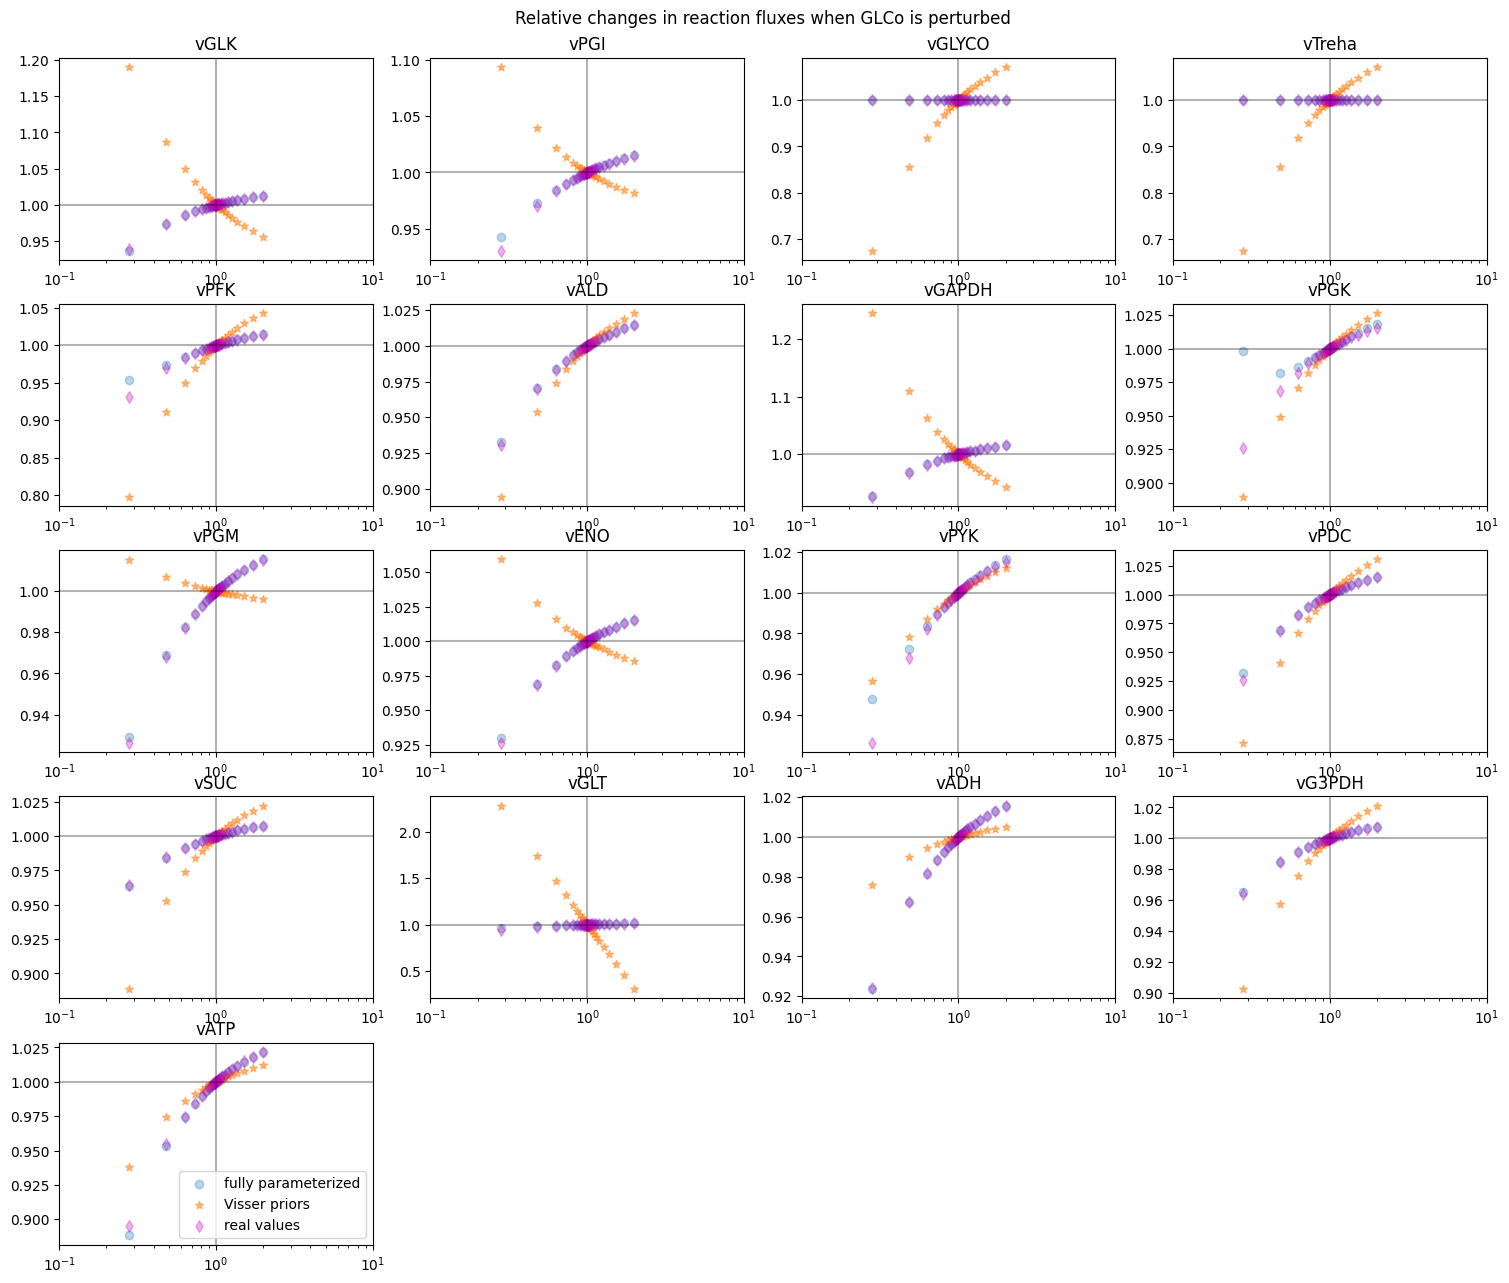

In [43]:
fig, axs = plt.subplots(5,4, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when GLCo is perturbed\n')
fig.tight_layout()

for i, rxn in enumerate(r.getReactionIds()):
  if i%4==0:
    idx_starter += 1
  
  axs[idx_starter, i%4].scatter(fp_rel_GLCo_perturbed_fluxes_df.columns, fp_rel_GLCo_perturbed_fluxes_df.loc[rxn], alpha=0.3)
  axs[idx_starter, i%4].scatter(vis_rel_GLCo_perturbed_fluxes_df.columns, vis_rel_GLCo_perturbed_fluxes_df.loc[rxn], alpha=0.5, marker='*')
  axs[idx_starter, i%4].scatter(rel_real_GLCo_values.columns, rel_real_GLCo_values.loc[rxn], alpha=0.3, c='m', marker='d')
  axs[idx_starter, i%4].set_xscale('log', base=10)
  axs[idx_starter, i%4].set_xlim([0.1, 10])
  axs[idx_starter, i%4].set_title(rxn)
  axs[idx_starter, i%4].axvline(1, alpha=0.3, c='k')
  axs[idx_starter, i%4].axhline(1, alpha=0.3, c='k')

fig.delaxes(axs[4,1]) 
fig.delaxes(axs[4,2]) 
fig.delaxes(axs[4,3]) 

plt.legend(["fully parameterized", "Visser priors", "real values"])
plt.show()